In [85]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression

In [86]:
NUM_DAYS = 10000    
INTERVAL = '1d'     
symbol = 'SP'

[*********************100%***********************]  1 of 1 completed
4433
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2004-06-02  6.235  6.545  6.165  6.545      6.545  109200
2004-06-03  6.550  7.345  6.485  6.485      6.485  186400
2004-06-04  6.650  6.650  6.445  6.475      6.475  146200
2004-06-07  6.450  6.615  6.350  6.395      6.395  120800
2004-06-08  6.425  6.760  6.425  6.590      6.590  258200


<AxesSubplot:xlabel='Date'>

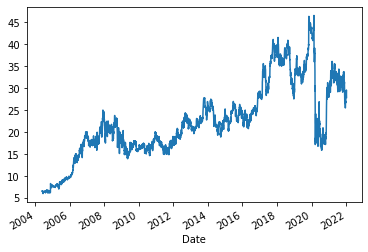

In [87]:
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)

print(len(data))

print(data.head())

data["Close"].plot()

<AxesSubplot:xlabel='Date'>

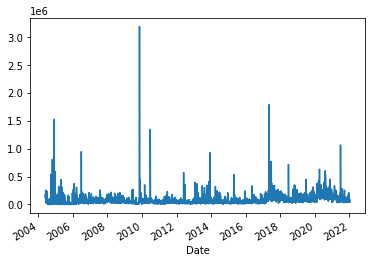

In [88]:
data["Volume"].plot()

<AxesSubplot:xlabel='Date'>

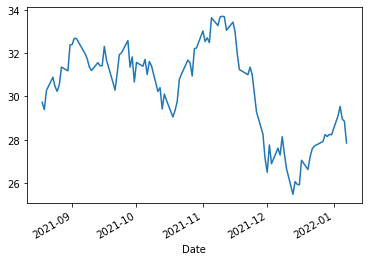

In [89]:
data.iloc[-100:]['Close'].plot()

                Open      High       Low     Close  Adj Close         Volume
Date                                                                        
2004-06-02  6.235000  6.545000  6.165000  6.545000   6.545000  109200.000000
2004-06-03  6.468334  7.137592  6.402037  6.500556   6.500556  166385.185185
2004-06-04  6.591706  6.806460  6.431214  6.483200   6.483200  152677.079796
2004-06-07  6.498194  6.680115  6.377621  6.424997   6.424997  131641.309907
2004-06-08  6.450367  6.732315  6.408580  6.532815   6.532815  214338.801197


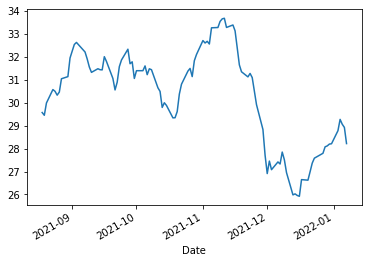

In [90]:
data = data.ewm(alpha=0.65).mean()
data = data.dropna()

data.iloc[-100:]['Close'].plot()

print(data.head())

In [91]:
live_pred_data = data.iloc[-100:-10]
live_pred_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-18,29.316261,30.034731,29.114246,29.574238,29.574238,119984.543659
2021-08-19,29.383691,29.719655,29.039986,29.454483,29.454483,150349.590281
2021-08-20,29.257792,30.161879,29.059495,29.991069,29.991069,99877.356598
2021-08-23,30.169227,30.706658,29.924323,30.575374,30.575374,67457.074809
2021-08-24,30.696229,31.072830,30.233513,30.500380,30.500380,63649.976183
...,...,...,...,...,...,...
2021-12-17,25.903621,26.902231,25.431282,26.648005,26.648005,157847.665377
2021-12-20,26.310768,26.868281,25.755449,26.623302,26.623302,121221.682882
2021-12-21,26.732768,27.155398,26.525407,26.991656,26.991656,90072.589009


In [92]:
def _produce_prediction(data, window):
    
    prediction = (data.shift(-window)['Close'] >= data['Close'])
    prediction = prediction.iloc[:-window]
    data['Pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['Close'])
data = data.dropna()
data.tail()
print(len(data))

print(data)


4418
                 Open       High        Low  Adj Close         Volume  Pred
Date                                                                       
2004-06-02   6.235000   6.545000   6.165000   6.545000  109200.000000   0.0
2004-06-03   6.468334   7.137592   6.402037   6.500556  166385.185185   0.0
2004-06-04   6.591706   6.806460   6.431214   6.483200  152677.079796   0.0
2004-06-07   6.498194   6.680115   6.377621   6.424997  131641.309907   0.0
2004-06-08   6.450367   6.732315   6.408580   6.532815  214338.801197   0.0
...               ...        ...        ...        ...            ...   ...
2021-12-10  27.591374  28.062536  26.739285  26.951636   72205.991956   1.0
2021-12-13  26.946981  27.111888  25.855749  25.982072   76427.097185   1.0
2021-12-14  25.960944  26.610161  25.566012  26.026225  165199.484015   1.0
2021-12-15  26.168331  26.395557  25.477604  25.957179  124574.819405   1.0
2021-12-16  26.188916  26.404945  25.693661  25.920012  108536.186792   1.0

[4418 

In [93]:
y = data['Pred']
features = [x for x in data.columns if x not in ['Pred']]
X = data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.33)

In [94]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test.values, rf_prediction)
print('Random Forest Classifier Accuracy = ' , rf_accuracy , "\n")
print(classification_report(y_test, rf_prediction))

Random Forest Classifier Accuracy =  0.6285038838230328 

              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60      1372
         1.0       0.65      0.65      0.65      1589

    accuracy                           0.63      2961
   macro avg       0.63      0.63      0.63      2961
weighted avg       0.63      0.63      0.63      2961



In [95]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test.values, knn_prediction)
print('KNeighbors Classifier Accuracy = ' , knn_accuracy , "\n")
print(classification_report(y_test, knn_prediction))
confusion_matrix_graph = confusion_matrix(y_test, knn_prediction)

KNeighbors Classifier Accuracy =  0.5038838230327592 

              precision    recall  f1-score   support

         0.0       0.46      0.41      0.43      1372
         1.0       0.53      0.58      0.56      1589

    accuracy                           0.50      2961
   macro avg       0.50      0.50      0.50      2961
weighted avg       0.50      0.50      0.50      2961



In [96]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test.values, lr_prediction)
print('Logistic Regression Classifier Accuracy = ' , lr_accuracy , "\n")
print(classification_report(y_test, lr_prediction))

Logistic Regression Classifier Accuracy =  0.5349544072948328 

              precision    recall  f1-score   support

         0.0       0.50      0.55      0.52      1372
         1.0       0.57      0.52      0.55      1589

    accuracy                           0.53      2961
   macro avg       0.54      0.54      0.53      2961
weighted avg       0.54      0.53      0.54      2961

